In [1]:
import pandas as pd
from nltk.stem import PorterStemmer
from gensim import corpora, models

import utils

from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
stemmer = PorterStemmer()

In [4]:
tdf = pd.read_csv('transcripts/transcripts.csv', index_col=0)

In [5]:
sdf = pd.read_csv('transcripts/speeches.csv', index_col=0)

In [6]:
sdf['tokens'] = sdf['text'].apply(lambda x: utils.process(x, stemmer=stemmer))

In [7]:
tdf['tokens'] = tdf['condensed'].apply(lambda x : utils.process(x, stemmer=stemmer)) 

In [9]:
texts = tdf['tokens'].tolist() + sdf['tokens'].tolist()

In [11]:
len(texts)

78564

In [10]:
dictionary = corpora.Dictionary(texts)

corpus = [dictionary.doc2bow(text) for text in texts]

ldamodel = models.ldamodel.LdaModel(corpus, num_topics=40, id2word=dictionary, passes=1)

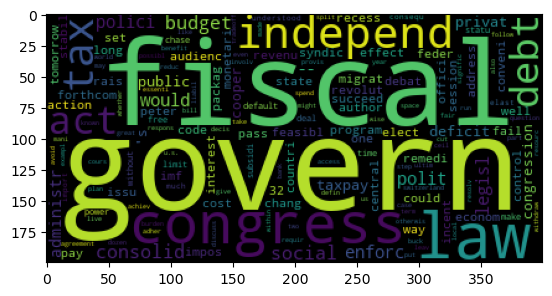

In [41]:
plt.imshow(WordCloud().fit_words(dict(ldamodel.show_topic(31, 200))))

In [40]:
ldamodel.show_topics(10, 10)

[(19,
  '0.055*"rate" + 0.049*"polici" + 0.036*"interest" + 0.034*"monetari" + 0.023*"letter" + 0.023*"latin" + 0.022*"small" + 0.018*"model" + 0.014*"effect" + 0.012*"rule"'),
 (0,
  '0.049*"polici" + 0.026*"rate" + 0.023*"feder" + 0.021*"monetari" + 0.018*"econom" + 0.016*"committe" + 0.014*"fomc" + 0.013*"economi" + 0.013*"market" + 0.011*"fund"'),
 (13,
  '0.027*"price" + 0.024*"hous" + 0.021*"home" + 0.014*"area" + 0.014*"construct" + 0.013*"sale" + 0.010*"inventori" + 0.009*"increas" + 0.009*"mass" + 0.009*"rural"'),
 (31,
  '0.071*"govern" + 0.056*"fiscal" + 0.032*"law" + 0.026*"congress" + 0.025*"independ" + 0.023*"tax" + 0.021*"debt" + 0.020*"act" + 0.019*"budget" + 0.018*"consolid"'),
 (1,
  '0.090*"bank" + 0.036*"capit" + 0.024*"credit" + 0.023*"regul" + 0.021*"institut" + 0.019*"loan" + 0.015*"lend" + 0.015*"requir" + 0.012*"risk" + 0.012*"liquid"'),
 (29,
  '0.082*"confer" + 0.039*"thank" + 0.032*"meet" + 0.030*"question" + 0.025*"today" + 0.024*"comment" + 0.022*"pleas" +